# **Parameter Optimisation for GITT** 

This notebook is created to provide an example for ```GITT``` optimisation problem. Diffisuion Coefficient is optimised in this notebook. Only voltage will be considered for optimisation in this example.
 The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pybamm
import pbparam
import pandas as pd
#from src import segment
import os
#import src

folder_path = (os.path.join(pbparam.__path__[0], "input", "data/GITT"))

# Get a list of all files in the folder
all_files = os.listdir(folder_path)

# Filter the list to get only .csv files
csv_files = [file for file in all_files if file.endswith('.csv')]

In [2]:
# Extract pulse numbers from filenames and sort them
pulse_numbers = [int(file_name.split('_')[1].split('.csv')[0]) for file_name in csv_files]
sorted_files_by_pulse = [f"pulse_{num}.csv" for num in sorted(pulse_numbers)]

# Loop through each CSV file and read it into a DataFrame
dfs = {}  # Store each DataFrame in a dictionary with the filename as the key

for csv_file in sorted_files_by_pulse:
    file_path = os.path.join(folder_path, csv_file)
    dfs[csv_file] = pd.read_csv(file_path)

In [3]:
dfs["pulse_1.csv"]["Positive electrode potential [V]"] - dfs["pulse_1.csv"]["Negative electrode potential [V]"] - dfs["pulse_1.csv"]["Voltage [V]"]

0      0.1286
1     -0.0144
2     -0.0215
3     -0.0224
4     -0.0224
        ...  
269   -0.0242
270   -0.0241
271   -0.0242
272   -0.0241
273   -0.0241
Length: 274, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


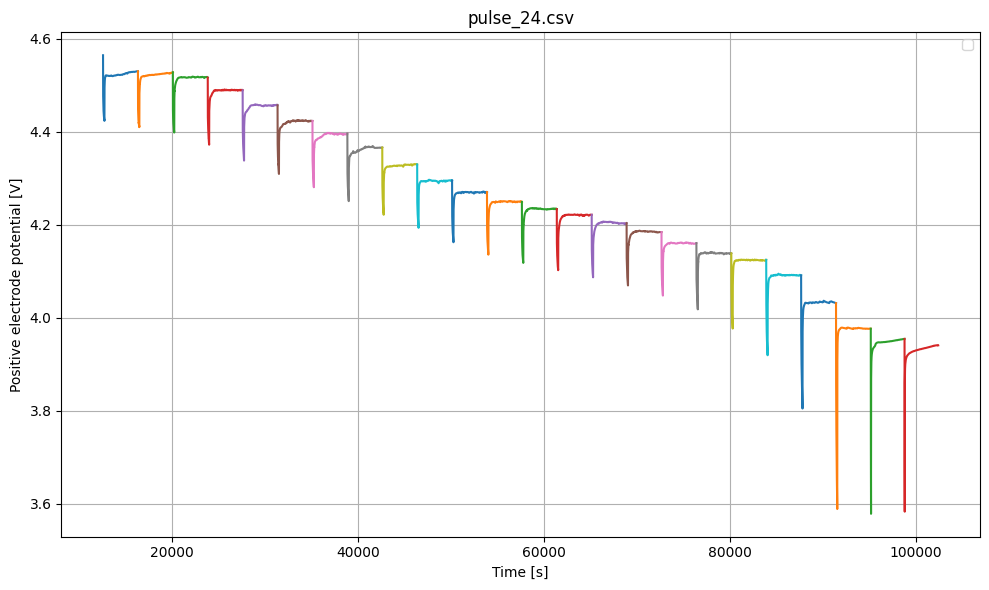

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
for file_name, df in dfs.items():
    plt.title(file_name)
    ax.plot(df['Time [s]'], df["Positive electrode potential [V]"])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Positive electrode potential [V]')
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()

[4.031, 3.9567, 3.9388, 3.9199, 3.8778, 3.8291, 3.7867, 3.7508, 3.7122, 3.6571, 3.5998, 3.5563, 3.521, 3.4931, 3.469, 3.4426, 3.4008, 3.348, 3.295, 3.2509, 3.1469, 3.0195, 2.8595, 2.7893]


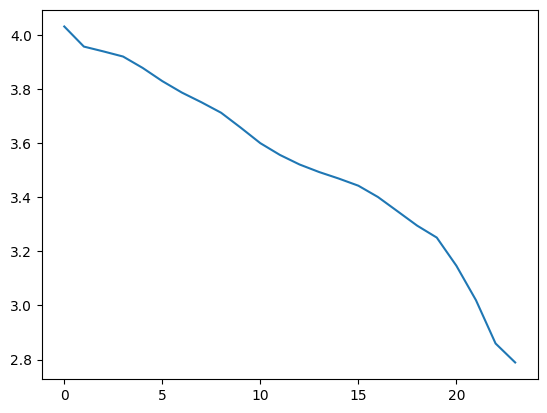

In [5]:
# Create a list to collect the first value from each DataFrame
first_values = [df['Voltage [V]'][0] for _, df in dfs.items()]
print(first_values)
plt.plot(first_values)

In [6]:
import numpy as np
np.gradient(first_values)

array([-0.0743 , -0.0461 , -0.0184 , -0.0305 , -0.0454 , -0.04555,
       -0.03915, -0.03725, -0.04685, -0.0562 , -0.0504 , -0.0394 ,
       -0.0316 , -0.026  , -0.02525, -0.0341 , -0.0473 , -0.0529 ,
       -0.04855, -0.07405, -0.1157 , -0.1437 , -0.1151 , -0.0702 ])

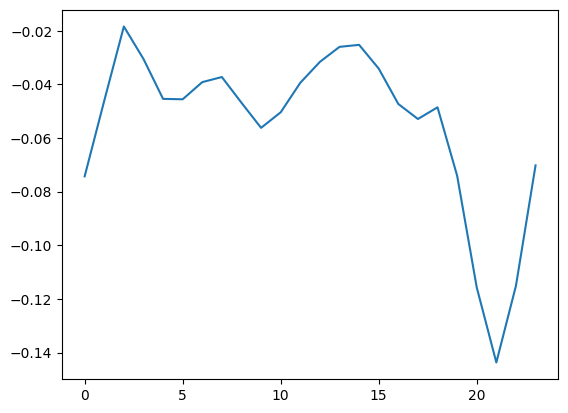

In [7]:
plt.plot(np.gradient(first_values))

We are creating a syntethic data first.

Synthethic data parameters are defined here:

Then, it is plotted:

The synthethic data is passed to a dataframe:

In [8]:
dfs['pulse_1.csv']["Time [s]"][0]

12637.8

In [9]:
d = {'Time [s]':(dfs['pulse_1.csv']["Time [s]"]-dfs['pulse_1.csv']["Time [s]"][0]), 
    'Voltage [V]': dfs['pulse_1.csv']["Voltage [V]"]}

data = pd.DataFrame(data = d)

In [10]:
data

,Time [s],Voltage [V]
0,0.00,4.0310
1,0.36,4.0194
2,1.08,4.0099
3,2.16,4.0040
4,3.24,3.9992
...,...,...
269,3510.00,4.1089
270,3569.76,4.1086
271,3629.88,4.1089
272,3690.00,4.1086


PbParam model to be used for GITT needs to be defined:

In [11]:
model = pbparam.BasicGITT()

Next, parameter dictionary needs to be defined with all of the required parameters:

In [12]:
param_dict=pybamm.ParameterValues({
        "Reference OCP [V]": 4.2,
        "Derivative of the OCP wrt stoichiometry [V]": -0.167,
        "Current function [A]": 0.680616,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Electrode width [m]": 0.207,
        "Electrode height [m]": 0.137,
        "Positive electrode active material volume fraction": 0.5,
        "Positive particle radius [m]": 1e-05,
        "Positive electrode thickness [m]": 0.0001,
        "Positive electrode diffusivity [m2.s-1]": 5e-14,
        "Maximum concentration in positive electrode [mol.m-3]": 51217.9257309275,
        "Initial concentration in positive electrode [mol.m-3]": 1000,
        "Effective resistance [Ohm]": 0,
        'Negative electrode thickness [m]': 0.0001,
        'Separator thickness [m]': 0.0001,
        'Negative particle radius [m]': 1e-05,
    })

In [13]:
# optimisation problem is GITT.
opt = pbparam.GITT(param_dict=param_dict,gitt_model=model, data=data)

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower value for most of the cases. 

In [14]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

After providing everything for optimisation algorithm, it can be performed using `optimise(optimisation_problem)`

In [15]:
result = optimiser.optimise(opt)
# optimised values of parameters and function values can be printed as below.
print(result)


             Optimal values: [2.06000000e-12 4.00727924e+00]
        Cost function value: 0.024403979587567966
                 Solve time: 385.001 ms
                    Message: Optimization terminated successfully.
        


```plot()``` function can be used to present result graphically.

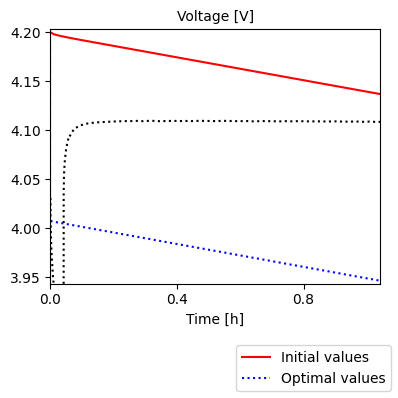

In [16]:
result.plot()